First convert the output of segmentation into a list of byte arrays instead of a list of binary numbers (this can also be done more directly obviously, but for now it works. 

In [64]:
def number_2_bytearray(num): 
    return bytearray(int(num,2).to_bytes((len(num)+7) // 8, byteorder='big'))

Let's take the example data as it is output by segmentation

In [65]:
data = ['0100100001100101011011000110110001101111001000000111011101101111011100100110110001100100001011000010000001001000011001010110110001101100011011110010000001110111011011110111001001101100011001000010110000100000010010000110010101101100011011000110111100100000',
'0111011101101111011100100110110001100100001011000010000001001000011001010110110001101100011011110010000001110111011011110111001001101100011001000010110000100000010010000110010101101100011011000110111100100000011101110110111101110010011011000110010000101100', '0010000001001000011001010110110001101100011011110010000001110111011011110111001001101100011001000010110000100000010010000110010101101100011011000110111100100000011101110110111101110010011011000110010000101100001000000100100001100101011011000110110001101111', '0010000001110111011011110111001001101100011001000010110000100000010010000110010101101100011011000110111100100000011101110110111101110010011011000110010000101100001000000100100001100101011011000110110001101111001000000111011101101111011100100110110001100100', '0010110000100000010010000110010101101100011011000110111100100000011101110110111101110010011011000110010000101100001000000100100001100101011011000110110001101111001000000111011101101111011100100110110001100100001011000010000001001000011001010110110001101100', '0110111100100000011101110110111101110010011011000110010000101100001000000100100001100101011011000110110001101111001000000111011101101111011100100110110001100100001011000010000001001000011001010110110001101100011011110010000001110111011011110111001001101100', '0110010000101100001000000100100001100101011011000110110001101111001000000111011101101111011100100110110001100100001011000010000001001000011001010110110001101100011011110010000001110111011011110111001001101100011001000010110000100000010010000110010101101100', '0110110001101111001000000111011101101111011100100110110001100100001011000010000001001000011001010110110001101100011011110010000001110111011011110111001001101100011001000010110000100000010010000110010101101100011011000110111100100000011101110110111101110010', '0110110001100100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000']

In [66]:
data_bytearray = []
for i in data:
    data_bytearray.append(number_2_bytearray(i))
data_bytearray

[bytearray(b'Hello world, Hello world, Hello '),
 bytearray(b'world, Hello world, Hello world,'),
 bytearray(b' Hello world, Hello world, Hello'),
 bytearray(b' world, Hello world, Hello world'),
 bytearray(b', Hello world, Hello world, Hell'),
 bytearray(b'o world, Hello world, Hello worl'),
 bytearray(b'd, Hello world, Hello world, Hel'),
 bytearray(b'lo world, Hello world, Hello wor'),
 bytearray(b'ld\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00')]

Now we can start using this to implement the formation of seeds. For now I'm just going to be using the robust solition distribution as described in the original paper, if we want we can later always change this distribution depending on what we think necessary. Also, since the implementation of the LFSR is implemented seperately. I will assume I am given a seed and need to generate the corresponding droplet.

In [73]:
import random
import math
import numpy as np
import functools
test_seed = 454761243
# convert the test seed into the index that will be packaged into the droplet.
# so for example with seed = 7 = 00000000 00000000 00000000 00000111. we create a byte array of these bytes.
# first convert to bytearray.
seed_array = bytearray(number_2_bytearray(bin(test_seed)))
if len(seed_array) < 4:  
    seed_index = bytearray(4-len(seed_array)) + seed_array
elif len(seed_array) > 4:
    if seed_array[0] == 0:
        del seed_array[0]
        seed_index = seed_array
    else:
        print("seed too big")
# create a Pseudo random number generator
prng = random.Random()


27


In order to use a rng to select following a specific distribution, we first need to calculate this distribution. Since the robus soliton distribution is the ideal soliton distribution plus some additional probabilities and normalized, we first calculate the ideal solition distribution. Using the formulas p(1) = 1/K and p(i) = 1/(i*(i-1)). (code inspiration from https://franpapers.com/en/algorithmic/2018-introduction-to-fountain-codes-lt-codes-with-python/) but rewritten so I can actually understand it LOL

In [25]:
def ideal_soliton(K) -> list: 
    # initialize with the first two values, p(0) = 0 and p(1) = 1/K
    probabilities = [0,1/K]
    # calculate the rest of the values using p(i) = 1/(i*(i-1))
    probabilities += [1/(i*(i-1)) for i in range(2, K+1)]
    return probabilities 

We can now use this to define our robust solition distribution, by adding the following probabilities. For i = 1 to K/R-1: p(i) = R/(i*K), for i = K/R: p(i) = (R*ln(R/delta))/K and for i = K/R+1 to K: p(i) = 0. With R = c*ln^2(K/delta)*sqrt(K).
as you can tell this now adds to more parameters c and delta to the distribution. These need to be tuned to achieve optimal decoding capability.

101


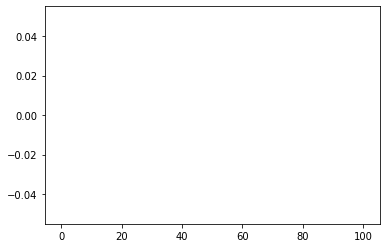

In [45]:
import matplotlib.pyplot as plt
def robust_soliton(K,c,delta) -> list:
    #initialize with the ideal distribution
    probabilities = ideal_soliton(K)
    # Define R
    R = c*(math.log(K/delta))*math.sqrt(K)
    # calculate the additional probabilities
    robust_probabilities = [0] + [R/(i*K) for i in range(1, int(K/R)-1)]
    robust_probabilities += [(R*math.log(R/delta))/K]
    robust_probabilities += [0 for i in range(int(K/R),K+1)]
    # add together
    probabilities = np.add(robust_probabilities, probabilities)
    #normalize 
    probabilities /= sum(probabilities)
    return probabilities
plt.bar(range(0,101), robust_soliton(100,0.1,0.05)[0])
print(len(range(0,101)))

We can then take a selection from this distribution using the python choices() method. This will tell us how many segments to include in a droplet. We can then use the choices() method again to select which segments will be included. (the bit about max_choices is only necessary cause the sample data is very small, but might be something to consider because small amounts of data can cause issues here.) 

In [47]:
prng.seed(test_seed)
max_choices = len(data_bytearray)
amount = prng.choices(range(0,101), robust_soliton(100,0.1,0.05), k = 1)[0]
segments = prng.sample(data_bytearray,k = amount)

we can then use the python reduce() method to apply our XOR to all the segments and create the final droplet, which we then append the seed to.

In [57]:
# create the droplet
droplet = seed_index + bytearray(functools.reduce(lambda i, j: bytes(a^b for (a, b) in zip(i,j)), segments))
len(droplet) 

36

Last but not least we can add the reed solomon codes.

In [52]:
import reedsolo 
# prepare reedsolomon
rsc = reedsolo.RSCodec(2)
# create the encoded droplet (what will eventually be stored in DNA)
encoded = rsc.encode(droplet)
# length of the encoded droplet is 38 as expected (32 data, 4 seed, 2 RS)
print(encoded, len(encoded))

bytearray(b'\x00\x00\x00\x07@DHello world, Hello world, Hell\xd8\xf6') 38


try to recover droplets from the seed.

In [53]:
prng.seed(test_seed)
amount_recovery = prng.choices(range(0,max_choices+1), robust_soliton(max_choices,0.1,0.05), k = 1)[0]
assert amount_recovery == amount 
#I can't think of a way to do this without having prior knowledge of the amount of stored data... something to discuss
segment_indices = prng.sample(range(len(data_bytearray)), k = amount_recovery)
segment_test = []
for i in segment_indices:
    segment_test.append(data_bytearray[i])
assert segment_test == segments
print(amount_recovery, segment_indices)

2 [4, 8]
